## Drosophila Examples for Pairwise Alignment

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
sys.path.insert(0,'../')
import morpho
import matplotlib.pyplot as plt
import scanpy
import numpy as np
from jupyterthemes import jtplot
jtplot.style(theme="onedork")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
%load_ext autoreload
%autoreload 2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
data_dir='../data/cellbin_h5ad'
slices = [scanpy.read_h5ad(os.path.join(data_dir, "E8-10_b_S{:0>2d}.h5ad".format(index))) for index in range(5,30)]

### Exact Alignment on CPU

In [29]:
i = 9
BAS_slices = [slice.copy() for slice in slices]
sliceA = BAS_slices[i]
sliceB = BAS_slices[i + 1]
align_model_A, align_model_B, P, vecfld = morpho.morpho_align_pairwise(
            model_ref=sliceA,
            model=sliceB,
            spatial_key="spatial",
            key_added="align_spatial",
            select_high_exp_genes=False,
            normalize_c=True,
            normalize_g=False,
            mode="SN",
            device="1",
            max_iter=100,
            dtype='float64',
            beta2=0.1,
            verbose=True,
            iter_key_added='iter_spatial',
            keep_size=False,
        )

|-----> Start alignment based on morph, mode: SN.
|-----> Filtered all samples for common genes. There are 8264 common genes.
|-----> Coordinates normalization params:
|-----------> Scale: 281.54830094026215.
|-----> [Start morpho alignment] in progress: 100.0000%
|-----> [Start morpho alignment] finished [1.1582s]
tensor(0.9900, device='cuda:0', dtype=torch.float64)


In [30]:
target_velocities = morpho.velocities(
    vecfld=vecfld, 
    quary_points=sliceB.obsm['spatial'],
    device="1",
    dtype='float64',
)

In [31]:
jacobian = morpho.jacobian(
    vecfld=vecfld, 
    quary_points=sliceB.obsm['spatial'],
    device="1",
    dtype='float64',
)

In [32]:
acc, acc_mat = morpho.acceleration(
    vecfld=vecfld, 
    quary_points=sliceB.obsm['spatial'],
    device="1",
    dtype='float64',
)

In [33]:
acc_mat

array([0.0826143 , 0.08219036, 0.08106434, ..., 0.06130547, 0.06629954,
       0.06315851])

In [34]:
curv, cur_mat = morpho.curvature(
    vecfld=vecfld, 
    quary_points=sliceB.obsm['spatial'],
    device="1",
    dtype='float64',
    formula=2,
)

|-----> [Calculating curvature] in progress: 100.0000%
|-----> [Calculating curvature] finished [0.0810s]


In [35]:
curl = morpho.curl(
    vecfld=vecfld, 
    quary_points=sliceB.obsm['spatial'],
    device="1",
    dtype='float64',
)

In [36]:
div = morpho.divergence(
    vecfld=vecfld, 
    quary_points=sliceB.obsm['spatial'],
    device="1",
    dtype='float64',
)

In [37]:
# grid_x = np.arange(np.min(align_model_B.obsm[spatial_key][:,0]),np.max(align_model_B.obsm[spatial_key][:,0]),10)
# grid_y = np.arange(np.min(align_model_B.obsm[spatial_key][:,1]),np.max(align_model_B.obsm[spatial_key][:,1]),10)
# grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
# quary_points = np.concatenate((grid_xx.reshape(-1,1), grid_yy.reshape(-1,1)), axis=-1)
# # quary_points = np.reshape(grid_xy, (-1,2))

In [38]:

# grid_velocities = morpho.velocities(
#     vecfld=vecfld, 
#     quary_points=quary_points,
#     device="1",
#     dtype='float64',
# )

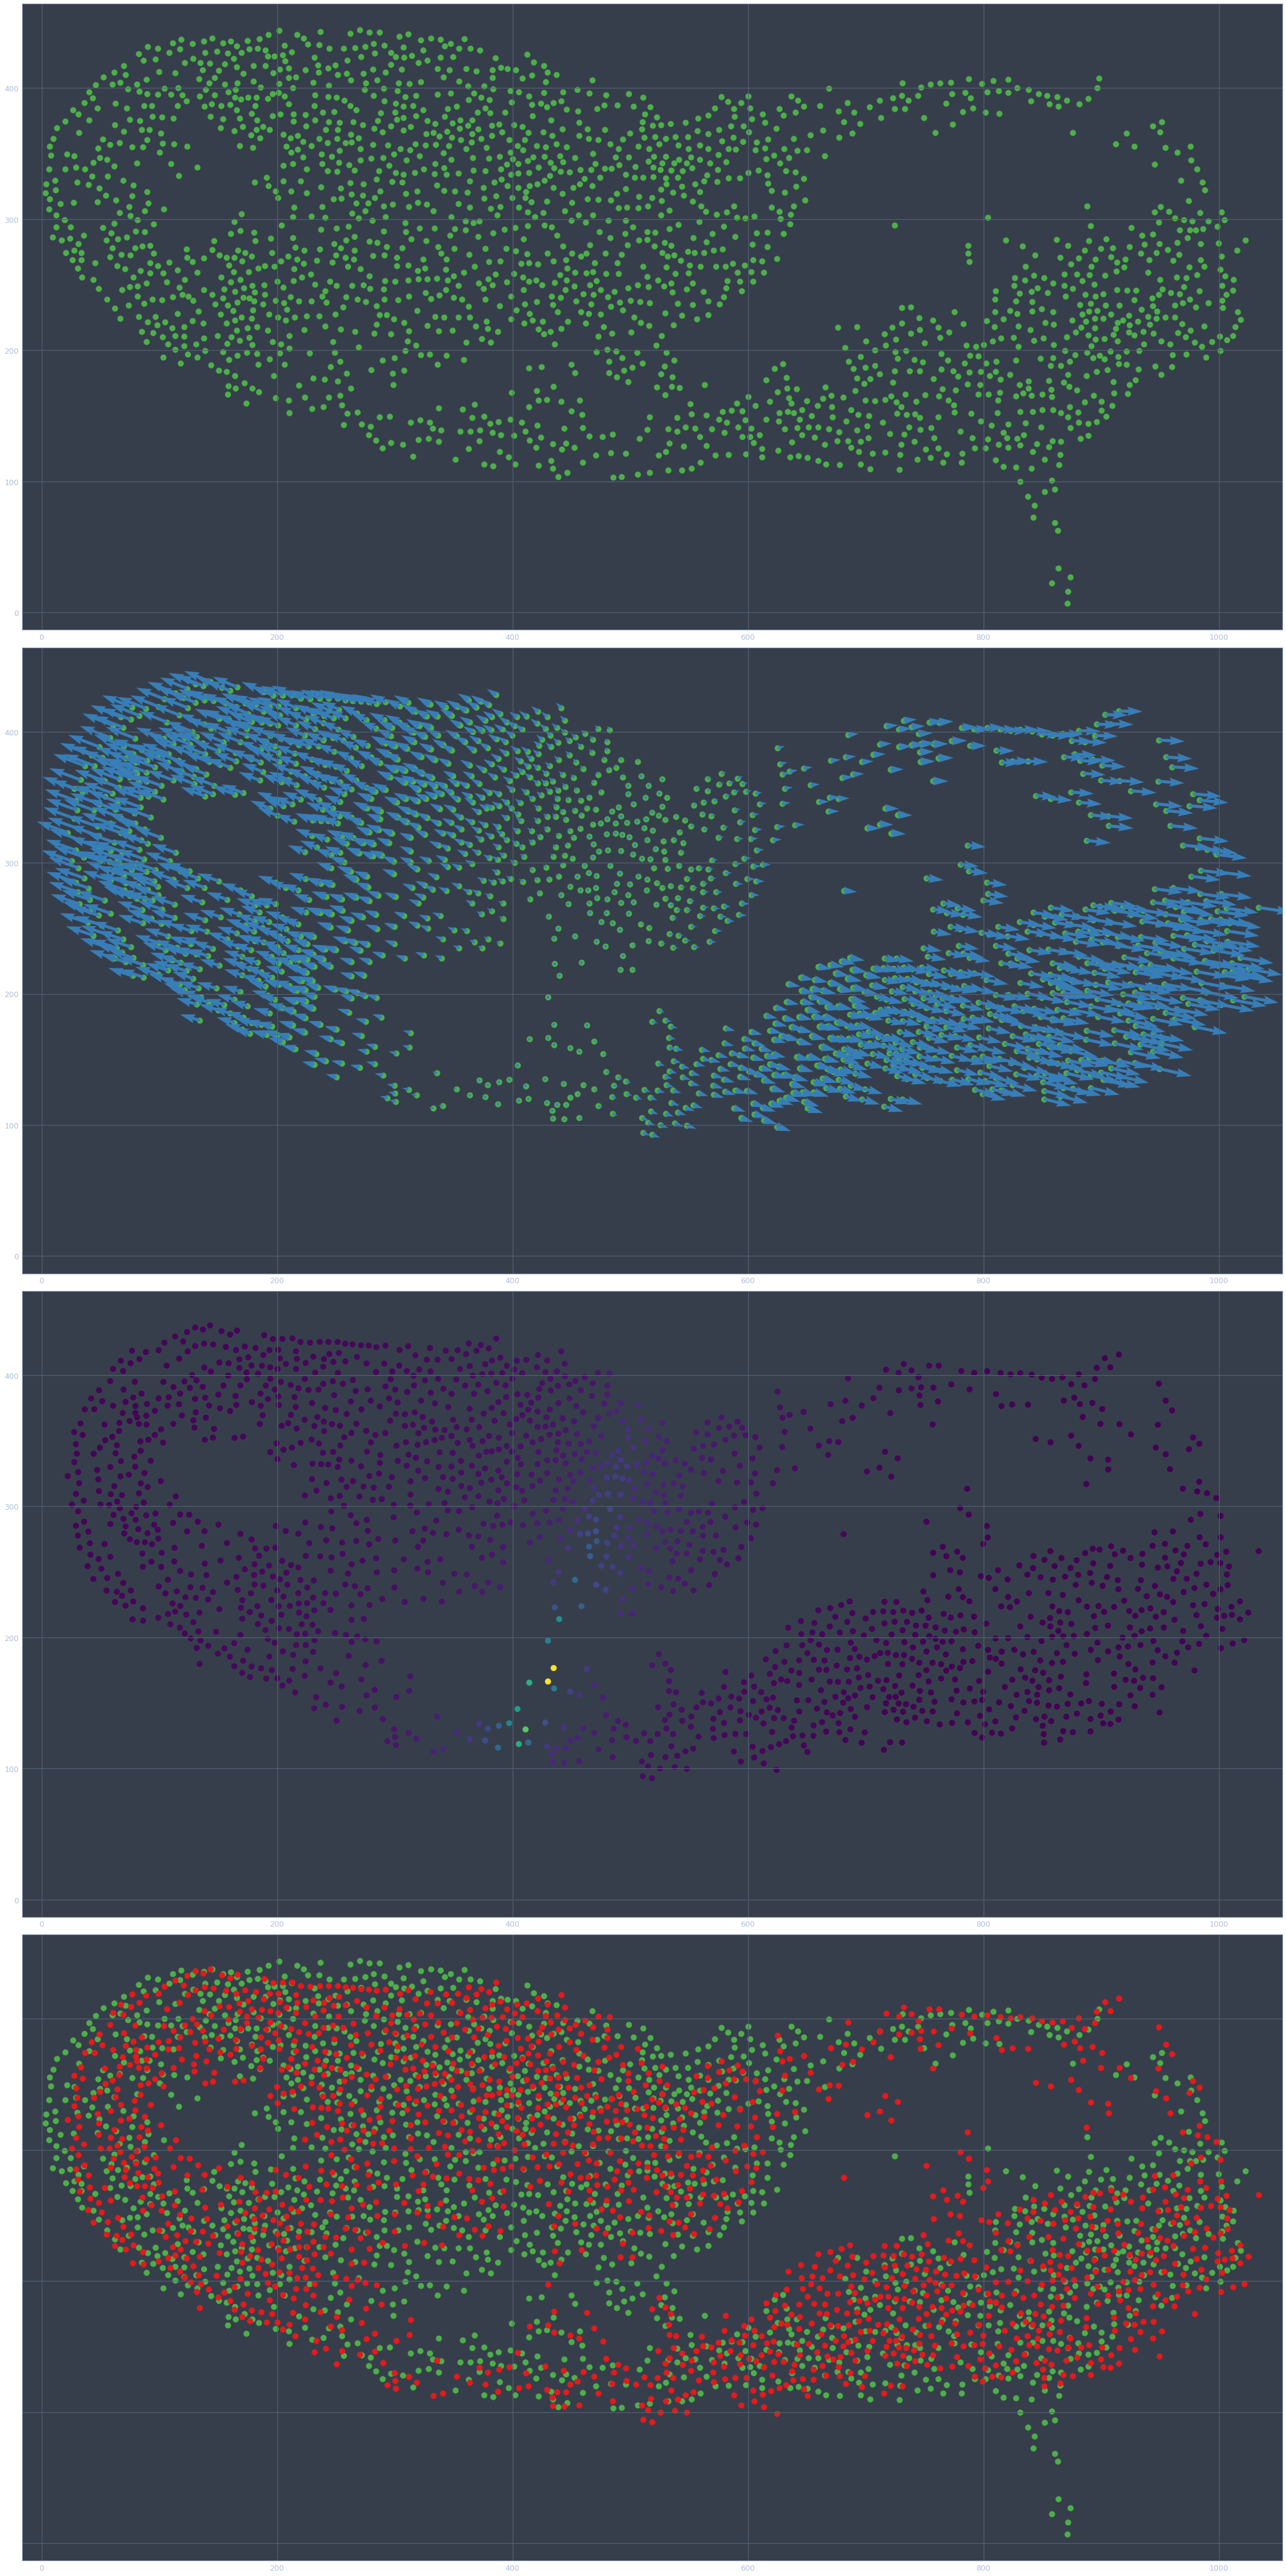

: 

In [46]:
spatial_key = 'spatial'
key_added="align_spatial"
%matplotlib inline
xmin,xmax = np.min([np.min(align_model_B.obsm['align_spatial'][:,0]),np.min(align_model_A.obsm['align_spatial'][:,0])]),np.max([np.max(align_model_B.obsm['align_spatial'][:,0]),np.max(align_model_A.obsm['align_spatial'][:,0])])
ymin,ymax = np.min([np.min(align_model_B.obsm['align_spatial'][:,1]),np.min(align_model_A.obsm['align_spatial'][:,1])]),np.max([np.max(align_model_B.obsm['align_spatial'][:,1]),np.max(align_model_A.obsm['align_spatial'][:,1])])
dot_size = 100
margin = 20
scale=(ymax-ymin+2*margin)/(xmax-xmin+2*margin)
fig, axs = plt.subplots(4, 1,figsize=(30,15*4))
axs[0].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
axs[0].set_xlim([xmin-margin,xmax+margin])
axs[0].set_ylim([ymin-margin,ymax+margin])
axs[1].scatter(align_model_B.obsm[key_added][:,0],align_model_B.obsm[key_added][:,1],s=dot_size,c=slice_colors[2])
axs[1].quiver(align_model_B.obsm[key_added][:,0],align_model_B.obsm[key_added][:,1],target_velocities[:,0],target_velocities[:,1],color=slice_colors[1],cmap='viridis')
axs[1].set_xlim([xmin-margin,xmax+margin])
axs[1].set_ylim([ymin-margin,ymax+margin])

axs[2].scatter(align_model_B.obsm[key_added][:,0],align_model_B.obsm[key_added][:,1],s=dot_size,c=curv)
# axs[2].quiver(align_model_B.obsm[key_added][:,0],align_model_B.obsm[key_added][:,1],-target_velocities[:,0],-target_velocities[:,1],color=slice_colors[1])
axs[2].set_xlim([xmin-margin,xmax+margin])
axs[2].set_ylim([ymin-margin,ymax+margin])

# axs[0,1].set_yticklabels([])
axs[3].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
axs[3].scatter(align_model_B.obsm['align_spatial'][:,0],align_model_B.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[0])
axs[3].set_xlim([xmin-margin,xmax+margin])
axs[3].set_ylim([ymin-margin,ymax+margin])
axs[3].set_yticklabels([])
plt.tight_layout()
plt.show()

In [40]:
# spatial_key = 'spatial'
# %matplotlib inline
# xmin,xmax = np.min([np.min(align_model_B.obsm['align_spatial'][:,0]),np.min(align_model_A.obsm['align_spatial'][:,0])]),np.max([np.max(align_model_B.obsm['align_spatial'][:,0]),np.max(align_model_A.obsm['align_spatial'][:,0])])
# ymin,ymax = np.min([np.min(align_model_B.obsm['align_spatial'][:,1]),np.min(align_model_A.obsm['align_spatial'][:,1])]),np.max([np.max(align_model_B.obsm['align_spatial'][:,1]),np.max(align_model_A.obsm['align_spatial'][:,1])])
# dot_size = 8
# margin = 20
# scale=(ymax-ymin+2*margin)/(xmax-xmin+2*margin)
# fig, axs = plt.subplots(2, 3,figsize=(30,20*scale))
# axs[0,0].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[0,0].set_xlim([xmin-margin,xmax+margin])
# axs[0,0].set_ylim([ymin-margin,ymax+margin])
# axs[0,1].scatter(align_model_B.obsm[spatial_key][:,0],align_model_B.obsm[spatial_key][:,1],s=dot_size,c=slice_colors[2])
# axs[0,1].quiver(align_model_B.obsm[spatial_key][:,0],align_model_B.obsm[spatial_key][:,1],target_velocities[:,0],target_velocities[:,1],color=slice_colors[2])
# axs[0,1].set_xlim([xmin-margin,xmax+margin])
# axs[0,1].set_ylim([ymin-margin,ymax+margin])
# # axs[0,1].set_yticklabels([])
# axs[0,2].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[0,2].scatter(align_model_B.obsm['align_spatial'][:,0],align_model_B.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[0])
# axs[0,2].set_xlim([xmin-margin,xmax+margin])
# axs[0,2].set_ylim([ymin-margin,ymax+margin])
# axs[0,2].set_yticklabels([])

# axs[1,0].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[1,0].set_xlim([xmin-margin,xmax+margin])
# axs[1,0].set_ylim([ymin-margin,ymax+margin])
# axs[1,1].scatter(align_model_B.obsm[spatial_key][:,0]+target_velocities[:,0],align_model_B.obsm[spatial_key][:,1]+target_velocities[:,1],s=dot_size,c=slice_colors[2])
# # axs[1,1].quiver(align_model_B.obsm[spatial_key][:,0],align_model_B.obsm[spatial_key][:,1],target_velocities[:,0],target_velocities[:,1],color=slice_colors[2],scale=1)
# axs[1,1].set_xlim([xmin-margin,xmax+margin])
# axs[1,1].set_ylim([ymin-margin,ymax+margin])
# axs[1,1].set_yticklabels([])
# axs[1,2].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[1,2].scatter(align_model_B.obsm[spatial_key][:,0]+target_velocities[:,0],align_model_B.obsm[spatial_key][:,1]+target_velocities[:,1],s=dot_size,c=slice_colors[0])
# axs[1,2].set_xlim([xmin-margin,xmax+margin])
# axs[1,2].set_ylim([ymin-margin,ymax+margin])
# axs[1,2].set_yticklabels([])
# plt.tight_layout()
# plt.show()

In [41]:
# spatial_key = 'spatial'
# %matplotlib inline
# xmin,xmax = np.min([np.min(align_model_B.obsm['align_spatial'][:,0]),np.min(align_model_A.obsm['align_spatial'][:,0])]),np.max([np.max(align_model_B.obsm['align_spatial'][:,0]),np.max(align_model_A.obsm['align_spatial'][:,0])])
# ymin,ymax = np.min([np.min(align_model_B.obsm['align_spatial'][:,1]),np.min(align_model_A.obsm['align_spatial'][:,1])]),np.max([np.max(align_model_B.obsm['align_spatial'][:,1]),np.max(align_model_A.obsm['align_spatial'][:,1])])
# dot_size = 8
# margin = 20
# scale=(ymax-ymin+2*margin)/(xmax-xmin+2*margin)
# fig, axs = plt.subplots(2, 3,figsize=(30,20*scale))
# axs[0,0].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[0,0].set_xlim([xmin-margin,xmax+margin])
# axs[0,0].set_ylim([ymin-margin,ymax+margin])
# axs[0,1].scatter(quary_points[:,0],quary_points[:,1],s=dot_size,c=slice_colors[2])
# axs[0,1].quiver(quary_points[:,0],quary_points[:,1],grid_velocities[:,0],grid_velocities[:,1],color=slice_colors[0])
# axs[0,1].set_xlim([xmin-margin,xmax+margin])
# axs[0,1].set_ylim([ymin-margin,ymax+margin])
# # axs[0,1].set_yticklabels([])
# axs[0,2].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[0,2].scatter(align_model_B.obsm['align_spatial'][:,0],align_model_B.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[0])
# axs[0,2].set_xlim([xmin-margin,xmax+margin])
# axs[0,2].set_ylim([ymin-margin,ymax+margin])
# axs[0,2].set_yticklabels([])

# axs[1,0].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[1,0].set_xlim([xmin-margin,xmax+margin])
# axs[1,0].set_ylim([ymin-margin,ymax+margin])
# axs[1,1].scatter(align_model_B.obsm[spatial_key][:,0]+target_velocities[:,0],align_model_B.obsm[spatial_key][:,1]+target_velocities[:,1],s=dot_size,c=slice_colors[2])
# # axs[1,1].quiver(align_model_B.obsm[spatial_key][:,0],align_model_B.obsm[spatial_key][:,1],target_velocities[:,0],target_velocities[:,1],color=slice_colors[2],scale=1)
# axs[1,1].set_xlim([xmin-margin,xmax+margin])
# axs[1,1].set_ylim([ymin-margin,ymax+margin])
# axs[1,1].set_yticklabels([])
# axs[1,2].scatter(align_model_A.obsm['align_spatial'][:,0],align_model_A.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
# axs[1,2].scatter(align_model_B.obsm[spatial_key][:,0]+target_velocities[:,0],align_model_B.obsm[spatial_key][:,1]+target_velocities[:,1],s=dot_size,c=slice_colors[0])
# axs[1,2].set_xlim([xmin-margin,xmax+margin])
# axs[1,2].set_ylim([ymin-margin,ymax+margin])
# axs[1,2].set_yticklabels([])
# plt.tight_layout()
# plt.show()